# Prophet Time Series Forecasting
## Coffee Shop Sales - 8 Year Forecast (2018-2025)

Notebook này chứa toàn bộ quy trình:
1. Load và chuẩn bị dữ liệu
2. Khám phá dữ liệu (EDA)
3. Train mô hình Prophet
4. Đánh giá mô hình
5. Dự báo 8 năm tương lai
6. Phân tích kết quả

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

c:\Coffee-shop\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Libraries imported successfully!


## 1. Load và Kiểm Tra Dữ Liệu

Cell này thực hiện:
- Load file CSV chứa dữ liệu doanh thu theo ngày và theo cửa hàng
- Hiển thị thông tin cơ bản về dataset (số rows, columns, data types)
- Kiểm tra missing values và data quality

### 1.1. Đọc Dataset Chính

Load dữ liệu doanh thu hàng ngày từ file CSV, bao gồm:
- Ngày giao dịch (ds)
- Mã cửa hàng (store_id)
- Doanh thu (y)
- Các features: trend, yearly, weekly seasonality

In [ ]:
# OPTIONAL: Chỉ chạy cell này nếu cần xử lý lại raw data
# Skip cell này nếu đã có file daily_sales_by_store.csv

# Load raw data
print("Loading raw data...")
stores_raw = pd.read_csv('../data/raw_data/stores.csv')
train_raw = pd.read_csv('../data/raw_data/train.csv')
transactions_raw = pd.read_csv('../data/raw_data/transactions.csv')

print(f"Stores: {len(stores_raw)} | Train: {len(train_raw):,} | Transactions: {len(transactions_raw):,}")

# Convert dates
train_raw['date'] = pd.to_datetime(train_raw['date'])
transactions_raw['date'] = pd.to_datetime(transactions_raw['date'])

# Aggregate by date + store
daily_sales_by_store = train_raw.groupby(['date', 'store_nbr']).agg({
    'sales': 'sum',
    'onpromotion': 'sum'
}).reset_index()
daily_sales_by_store.columns = ['ds', 'store_nbr', 'y', 'promotions']

# Merge store info
daily_sales_by_store = daily_sales_by_store.merge(stores_raw, on='store_nbr', how='left')

# Merge transactions
daily_sales_by_store = daily_sales_by_store.merge(
    transactions_raw,
    left_on=['ds', 'store_nbr'],
    right_on=['date', 'store_nbr'],
    how='left'
).drop('date', axis=1)

daily_sales_by_store['transactions'] = daily_sales_by_store['transactions'].fillna(0)

# Reorder columns
daily_sales_by_store = daily_sales_by_store[[
    'ds', 'store_nbr', 'city', 'state', 'type', 'cluster',
    'y', 'promotions', 'transactions'
]].sort_values(['ds', 'store_nbr']).reset_index(drop=True)

# Save
daily_sales_by_store.to_csv('../data/daily_sales_by_store.csv', index=False)

print(f"\nProcessed {len(daily_sales_by_store):,} records")
print(f"Saved to: ../data/daily_sales_by_store.csv")
print(f"\nTop 5 stores:")
print(daily_sales_by_store.groupby('store_nbr')['y'].sum().sort_values(ascending=False).head())

In [3]:
# Load daily sales data
df = pd.read_csv('../data/daily_sales_cafe.csv')
df['ds'] = pd.to_datetime(df['ds'])

print(f"Data shape: {df.shape}")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total days: {len(df)} days")
print(f"\nFirst rows:")
df.head(10)

Data shape: (1688, 3)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Total days: 1688 days

First rows:


,ds,y,promotions
0,2013-01-01,990.58900,0.0
1,2013-01-02,98338.31900,0.0
2,2013-01-03,70561.48002,0.0
3,2013-01-04,70888.96901,0.0
4,2013-01-05,100185.76108,0.0
5,2013-01-06,113045.66500,0.0
6,2013-01-07,69265.15100,0.0
7,2013-01-08,62746.76402,0.0
8,2013-01-09,63912.83002,0.0
9,2013-01-10,56524.59703,0.0


In [4]:
# Basic statistics
print("Sales Statistics:")
print(df['y'].describe())
print(f"\nTotal Revenue: ${df['y'].sum():,.2f}")
print(f"Average Daily Sales: ${df['y'].mean():,.2f}")

Sales Statistics:
count      1688.000000
mean     153488.407332
std       68978.842948
min           0.000000
25%       91988.703500
50%      151773.997010
75%      197984.898575
max      385797.716980
Name: y, dtype: float64

Total Revenue: $259,088,431.58
Average Daily Sales: $153,488.41


## 2. Exploratory Data Analysis (EDA)

Phân tích khám phá dữ liệu để hiểu:
- Phân bố doanh thu
- Xu hướng theo thời gian
- Mối quan hệ giữa các biến

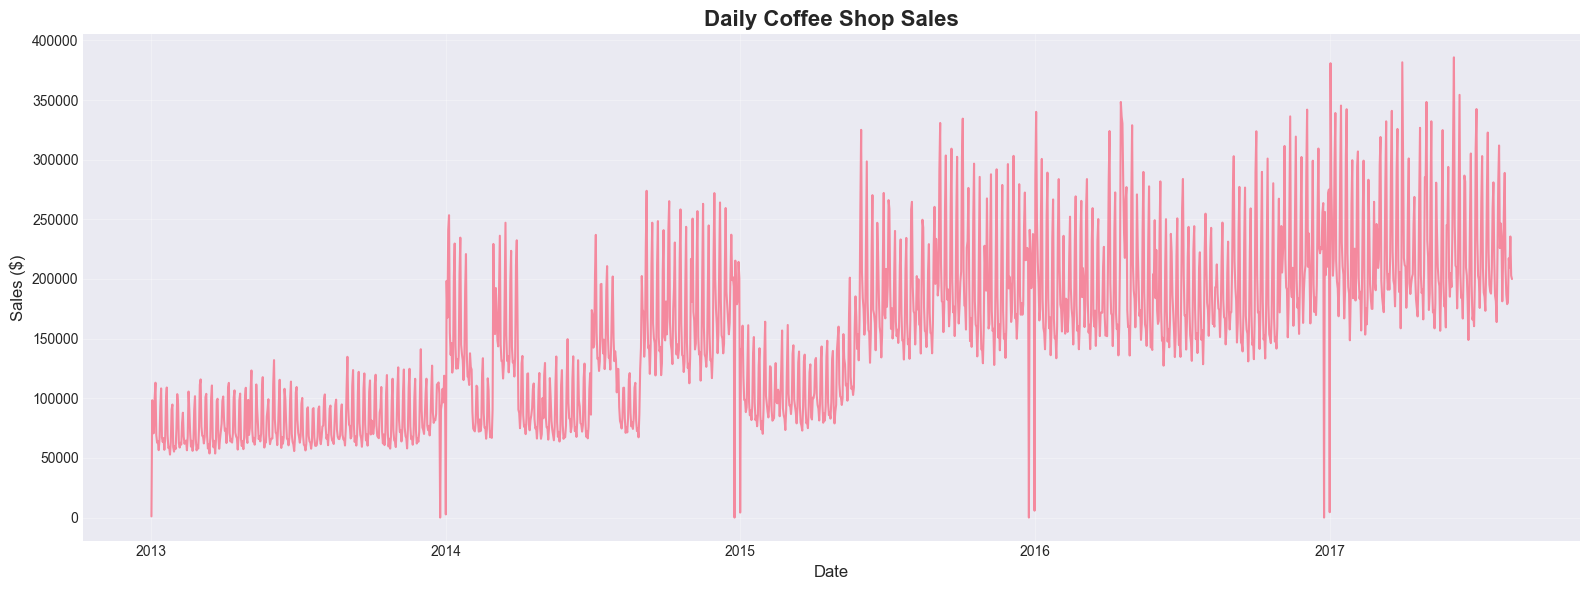

Plot saved: results/01_daily_sales.png


In [5]:
# Plot time series
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['ds'], df['y'], linewidth=1.5, alpha=0.8)
ax.set_title('Daily Coffee Shop Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/01_daily_sales.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/01_daily_sales.png")

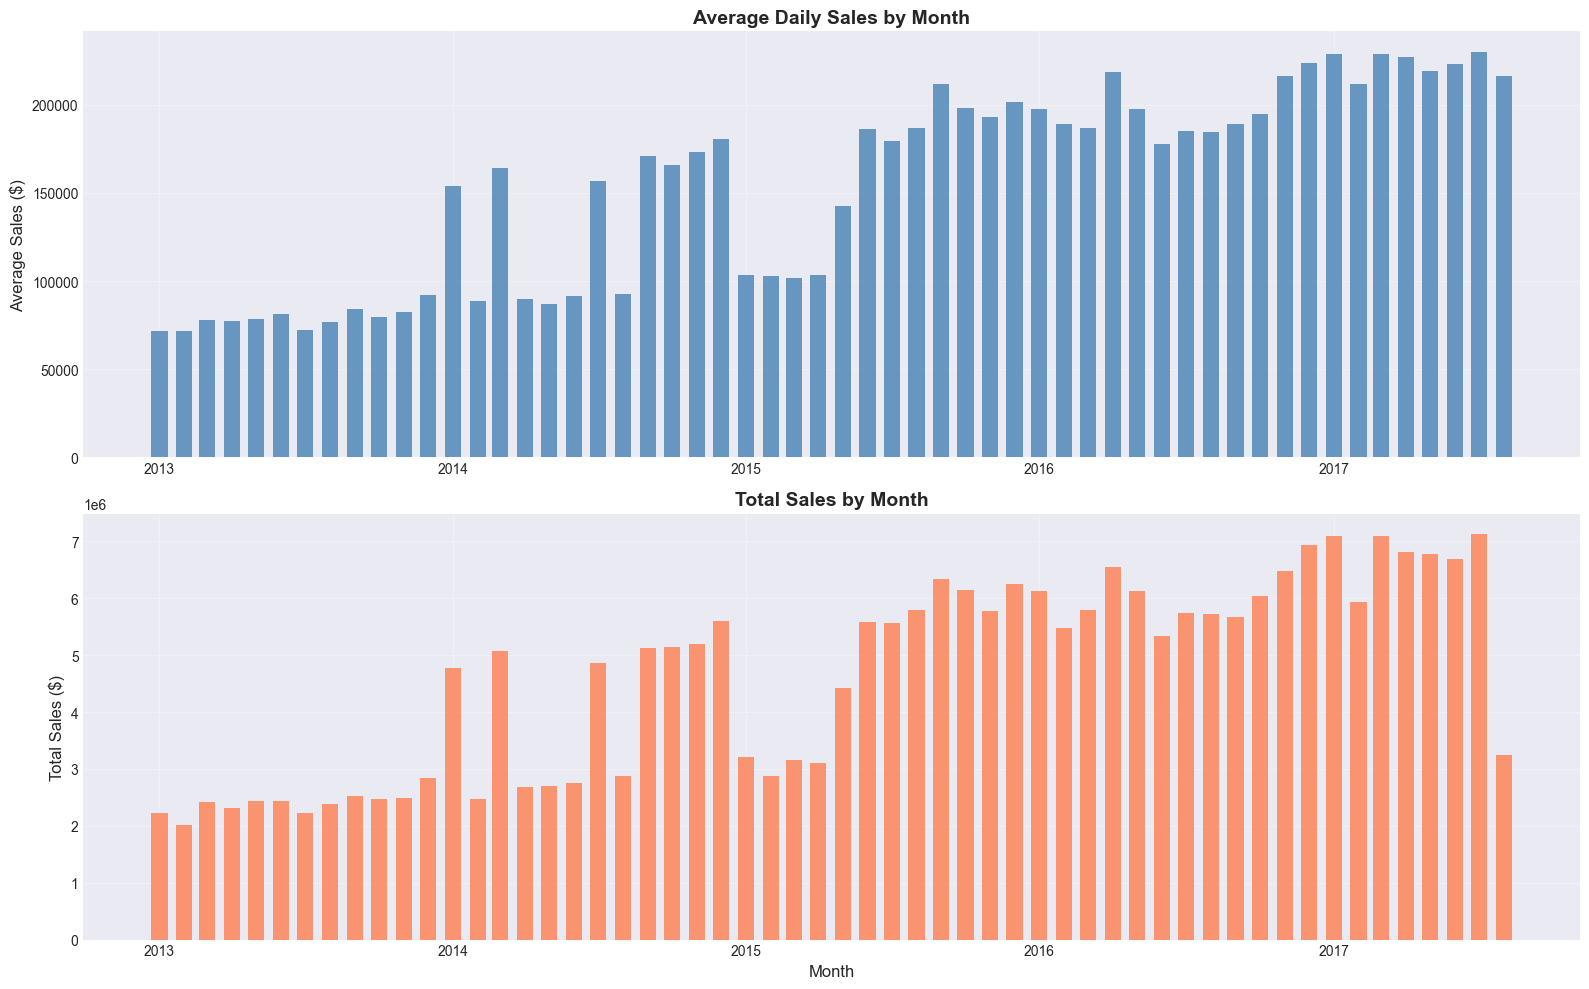

Plot saved: results/02_monthly_sales.png


In [6]:
# Monthly aggregation
df['year_month'] = df['ds'].dt.to_period('M')
monthly = df.groupby('year_month')['y'].agg(['mean', 'sum', 'count']).reset_index()
monthly['year_month'] = monthly['year_month'].dt.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Monthly average
axes[0].bar(monthly['year_month'], monthly['mean'], width=20, alpha=0.8, color='steelblue')
axes[0].set_title('Average Daily Sales by Month', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Sales ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Monthly total
axes[1].bar(monthly['year_month'], monthly['sum'], width=20, alpha=0.8, color='coral')
axes[1].set_title('Total Sales by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Sales ($)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/02_monthly_sales.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/02_monthly_sales.png")

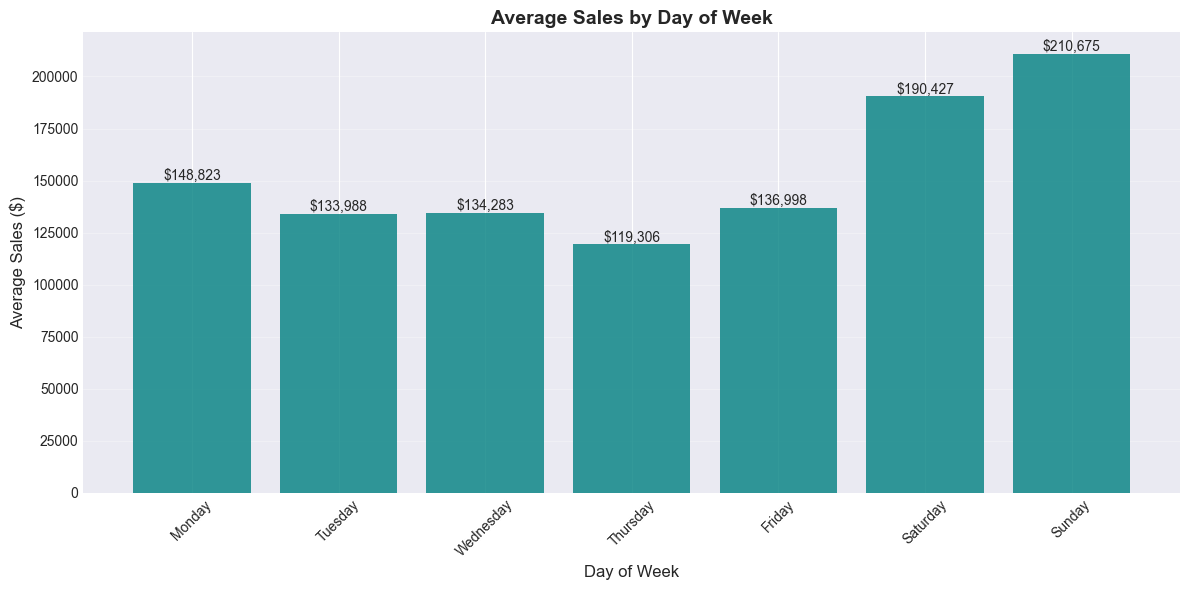

Plot saved: results/03_day_of_week.png


In [7]:
# Day of week pattern
df['day_of_week'] = df['ds'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = df.groupby('day_of_week')['y'].mean().reindex(dow_order)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(dow_sales.index, dow_sales.values, alpha=0.8, color='teal')
ax.set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Average Sales ($)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/03_day_of_week.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/03_day_of_week.png")

### 3. Load Holidays Data

**Mục đích:** Load dữ liệu các ngày lễ từ file đã chuẩn bị trước.

**Thực hiện:** Đọc file `holidays_prepared.csv` chứa danh sách các ngày lễ, chuyển đổi cột `ds` sang datetime format, và chuẩn bị theo format yêu cầu của Prophet model (thêm lower_window và upper_window để mô hình biết ảnh hưởng của ngày lễ lan rộng ra 2 ngày trước và sau).

In [8]:
# Load holidays
try:
    holidays = pd.read_csv('../data/holidays_prepared.csv')
    holidays['ds'] = pd.to_datetime(holidays['ds'])
    
    # Prepare for Prophet format
    holidays_prophet = holidays[['ds', 'holiday']].copy()
    holidays_prophet['lower_window'] = -2  # 2 days before
    holidays_prophet['upper_window'] = 2   # 2 days after
    
    print(f"Loaded {len(holidays_prophet)} holidays")
    print(f"\nSample holidays:")
    print(holidays_prophet.head(10))
    
    has_holidays = True
except FileNotFoundError:
    print("WARNING: Holidays file not found. Will use Ecuador country holidays only.")
    holidays_prophet = None
    has_holidays = False

Loaded 350 holidays

Sample holidays:
          ds                        holiday  lower_window  upper_window
0 2012-03-02             Fundacion de Manta            -2             2
1 2012-04-01  Provincializacion de Cotopaxi            -2             2
2 2012-04-12            Fundacion de Cuenca            -2             2
3 2012-04-14      Cantonizacion de Libertad            -2             2
4 2012-04-21      Cantonizacion de Riobamba            -2             2
5 2012-05-12         Cantonizacion del Puyo            -2             2
6 2012-06-23      Cantonizacion de Guaranda            -2             2
7 2012-06-25  Provincializacion de Imbabura            -2             2
8 2012-06-25     Cantonizacion de Latacunga            -2             2
9 2012-06-25           Fundacion de Machala            -2             2


### 3.1. Load Dữ Liệu Ngày Lễ

Load danh sách ngày lễ để đưa vào model:
- Tết, Noel, các ngày lễ lớn
- Format theo yêu cầu của Prophet (holiday, ds columns)
- Merge với dataset chính để model hiểu holiday effects

In [9]:
# Prepare training data (chỉ cần ds và y)
train_df = df[['ds', 'y']].copy()

print(f"Training data shape: {train_df.shape}")
print(f"Date range: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nSample:")
train_df.head()

Training data shape: (1688, 2)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

Sample:


,ds,y
0,2013-01-01,990.58900
1,2013-01-02,98338.31900
2,2013-01-03,70561.48002
3,2013-01-04,70888.96901
4,2013-01-05,100185.76108


### 3.2. Split Data theo Store

Chia dữ liệu thành 100 datasets riêng biệt, mỗi store một dataset:
- Mục đích: Train riêng model cho từng cửa hàng
- Lý do: Mỗi store có patterns và xu hướng khác nhau
- Kết quả: 100 dataframes, mỗi cái chứa lịch sử của 1 store

In [10]:
print("="*70)
print("TRAINING PROPHET MODEL")
print("="*70)

# Initialize Prophet with configuration
config = {
    'growth': 'linear',
    'changepoint_prior_scale': 0.05,
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': 20,
    'weekly_seasonality': 10,
    'daily_seasonality': False,
    'interval_width': 0.95
}

print("\nModel Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Create model with or without custom holidays
if has_holidays and holidays_prophet is not None:
    model = Prophet(holidays=holidays_prophet, **config)
    print(f"\nAdded {len(holidays_prophet)} custom holidays")
else:
    model = Prophet(**config)

# Add Ecuador country holidays
model.add_country_holidays(country_name='EC')
print("Added Ecuador country holidays")

TRAINING PROPHET MODEL

Model Configuration:
  growth: linear
  changepoint_prior_scale: 0.05
  seasonality_mode: multiplicative
  yearly_seasonality: 20
  weekly_seasonality: 10
  daily_seasonality: False
  interval_width: 0.95

Added 350 custom holidays

Added 350 custom holidays
Added Ecuador country holidays
Added Ecuador country holidays


In [11]:
# Train model
print("\nTraining Prophet model...")
start_time = datetime.now()

model.fit(train_df)

training_time = (datetime.now() - start_time).total_seconds()
print(f"Training completed in {training_time:.2f} seconds")
print(f"Training data: {len(train_df)} days ({train_df['ds'].min()} to {train_df['ds'].max()})")


Training Prophet model...


16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:46 - cmdstanpy - INFO - Chain [1] done processing
16:53:46 - cmdstanpy - INFO - Chain [1] done processing


Training completed in 14.57 seconds
Training data: 1688 days (2013-01-01 00:00:00 to 2017-08-15 00:00:00)


## 4. Train Prophet Models

Train 100 Prophet models, mỗi model cho 1 store:
- Cấu hình: yearly_seasonality, weekly_seasonality, holidays
- Hyperparameters: changepoint_prior_scale, seasonality_mode
- Output: 100 trained models lưu vào ml-models/store_models/

In [12]:
# Generate 8-year forecast
periods = 2920  # 8 years * 365 days
print(f"Generating {periods} days ({periods/365:.1f} years) forecast...")

# Create future dataframe
future = model.make_future_dataframe(periods=periods, freq='D')

print(f"Future dataframe shape: {future.shape}")
print(f"Date range: {future['ds'].min()} to {future['ds'].max()}")

# Predict
forecast = model.predict(future)

print(f"\nForecast completed!")
print(f"Forecast columns: {forecast.columns.tolist()[:10]}...")

Generating 2920 days (8.0 years) forecast...
Future dataframe shape: (4608, 1)
Date range: 2013-01-01 00:00:00 to 2025-08-13 00:00:00

Forecast completed!
Forecast columns: ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', "All Souls' Day", "All Souls' Day_lower", "All Souls' Day_upper", 'Batalla de Pichincha']...

Forecast completed!
Forecast columns: ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', "All Souls' Day", "All Souls' Day_lower", "All Souls' Day_upper", 'Batalla de Pichincha']...


In [13]:
# Split into in-sample and out-of-sample
train_end = train_df['ds'].max()
in_sample = forecast[forecast['ds'] <= train_end].copy()
out_sample = forecast[forecast['ds'] > train_end].copy()

print(f"Forecast split:")
print(f"  In-sample (training period): {len(in_sample)} days")
print(f"  Out-of-sample (future): {len(out_sample)} days ({len(out_sample)/365:.1f} years)")
print(f"\nOut-of-sample period: {out_sample['ds'].min()} to {out_sample['ds'].max()}")

Forecast split:
  In-sample (training period): 1688 days
  Out-of-sample (future): 2920 days (8.0 years)

Out-of-sample period: 2017-08-16 00:00:00 to 2025-08-13 00:00:00


### 4.1. Train Model cho Sample Store

Demo training process cho 1 store cụ thể:
- Chọn store #44 (Quito) làm ví dụ
- Fit Prophet model với data của store này
- Visualize forecast results
- Phân tích components (trend, seasonality)

In [14]:
# Merge actual and predicted for evaluation
eval_df = train_df.merge(
    in_sample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='inner'
)

# Calculate metrics
mae = np.mean(np.abs(eval_df['y'] - eval_df['yhat']))

# MAPE: exclude zero values to avoid inf
eval_df_nonzero = eval_df[eval_df['y'] != 0]
mape = np.mean(np.abs((eval_df_nonzero['y'] - eval_df_nonzero['yhat']) / eval_df_nonzero['y'])) * 100

rmse = np.sqrt(np.mean((eval_df['y'] - eval_df['yhat']) ** 2))

# Coverage (percentage of actuals within prediction interval)
in_interval = ((eval_df['y'] >= eval_df['yhat_lower']) & 
               (eval_df['y'] <= eval_df['yhat_upper']))
coverage = in_interval.mean() * 100

print("="*70)
print("MODEL EVALUATION METRICS (In-Sample)")
print("="*70)
print(f"Sample size: {len(eval_df)} days")
print(f"MAE:  ${mae:,.2f}")
print(f"MAPE: {mape:.2f}% (calculated on {len(eval_df_nonzero)} non-zero days)")
print(f"RMSE: ${rmse:,.2f}")
print(f"Coverage (95% CI): {coverage:.2f}% (target: 95%)")
print("="*70)

MODEL EVALUATION METRICS (In-Sample)
Sample size: 1688 days
MAE:  $11,623.18
MAPE: 9.98% (calculated on 1684 non-zero days)
RMSE: $16,331.83
Coverage (95% CI): 93.78% (target: 95%)


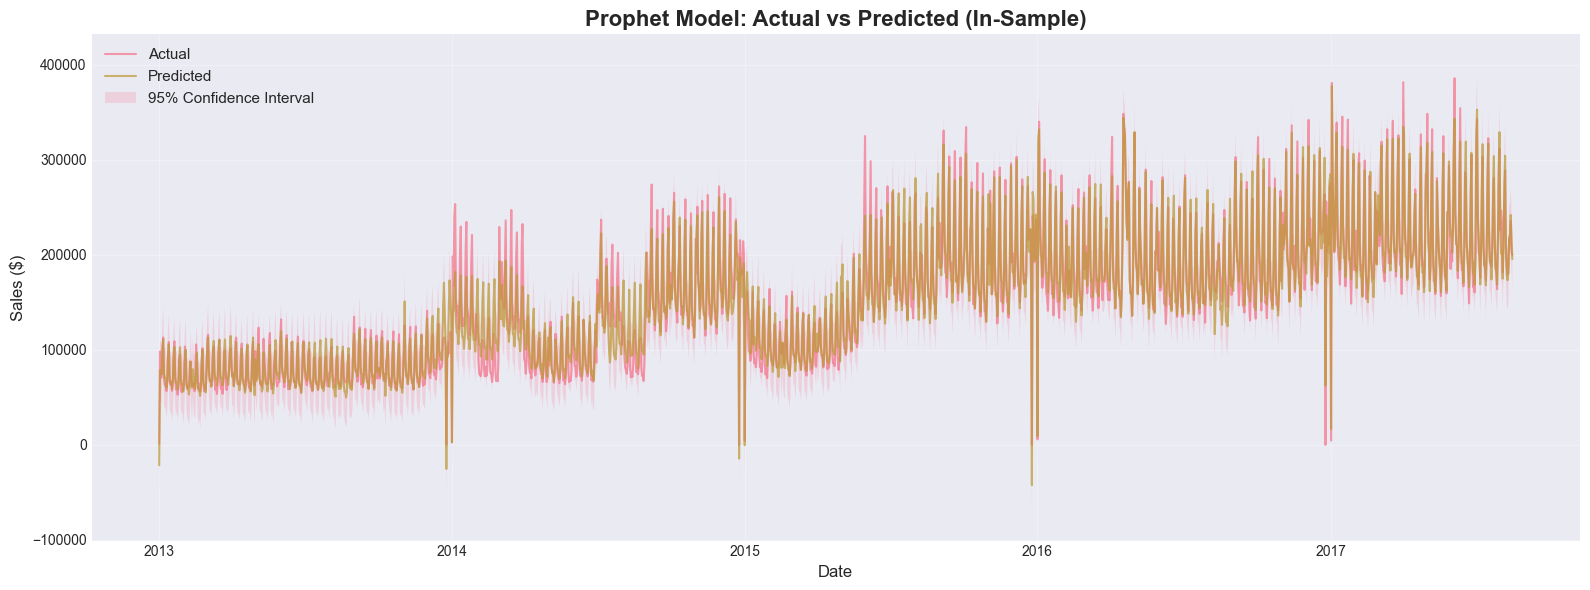

Plot saved: results/04_actual_vs_predicted.png


In [15]:
# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(eval_df['ds'], eval_df['y'], label='Actual', linewidth=1.5, alpha=0.7)
ax.plot(eval_df['ds'], eval_df['yhat'], label='Predicted', linewidth=1.5, alpha=0.7)
ax.fill_between(eval_df['ds'], eval_df['yhat_lower'], eval_df['yhat_upper'], 
                 alpha=0.2, label='95% Confidence Interval')
ax.set_title('Prophet Model: Actual vs Predicted (In-Sample)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/04_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/04_actual_vs_predicted.png")

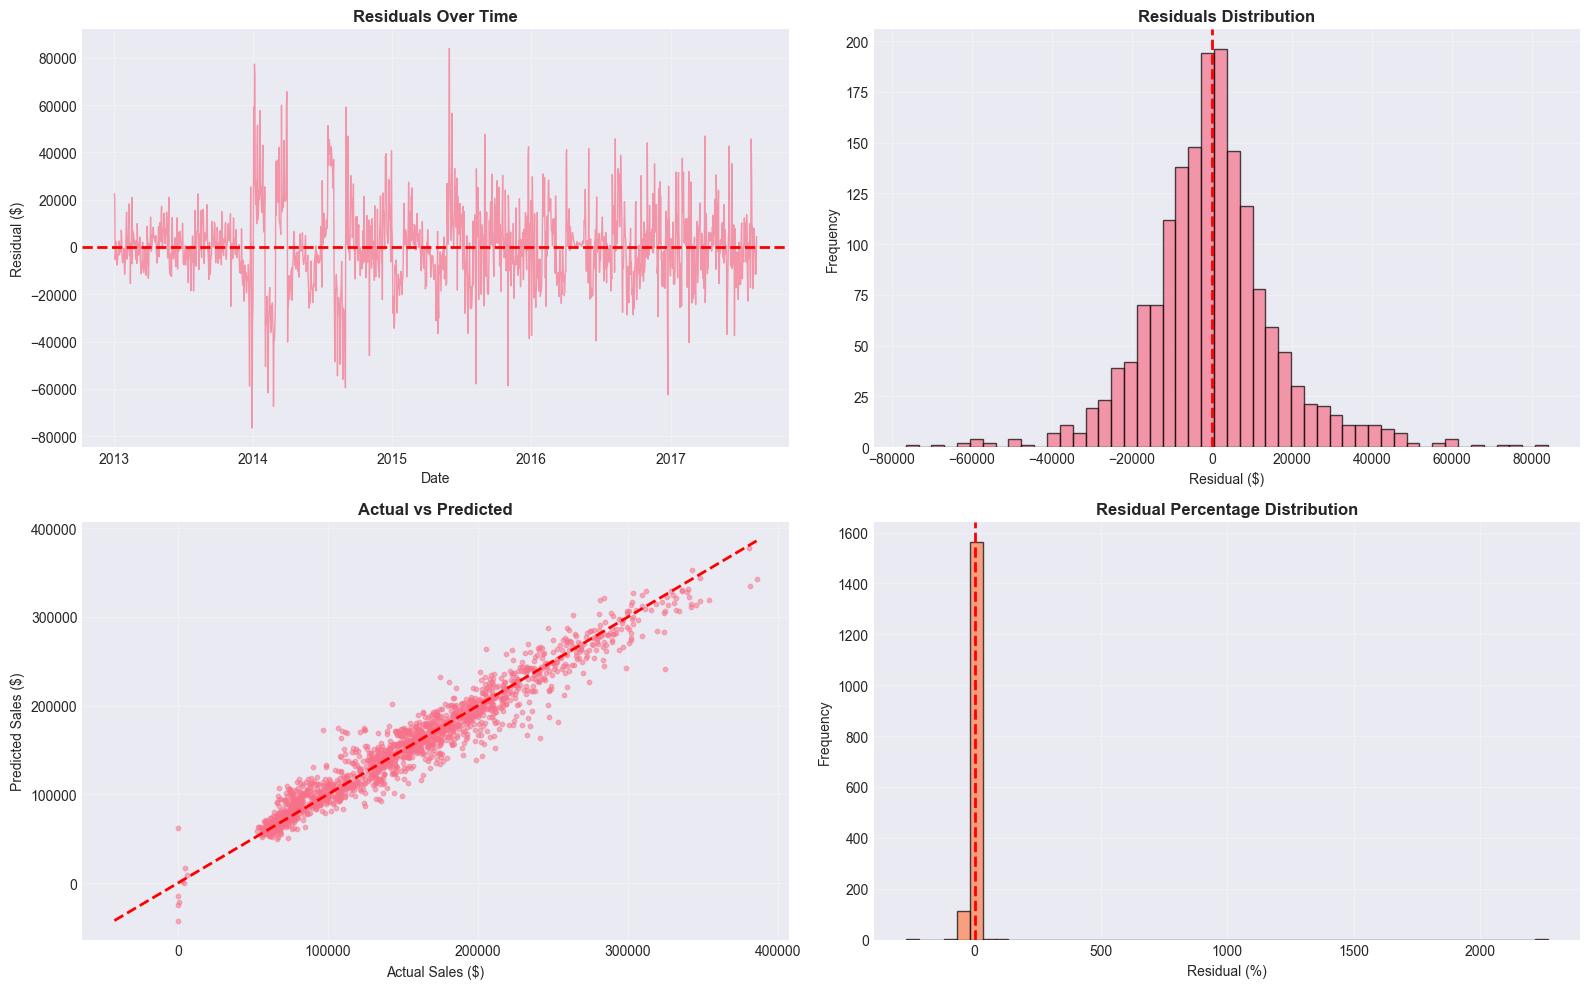

Plot saved: results/05_residuals_analysis.png


In [16]:
# Residuals analysis
eval_df['residual'] = eval_df['y'] - eval_df['yhat']
# Fix: Replace inf values with NaN for percentage calculation
eval_df['residual_pct'] = np.where(
    eval_df['y'] != 0,
    (eval_df['residual'] / eval_df['y']) * 100,
    np.nan
)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Residuals over time
axes[0, 0].plot(eval_df['ds'], eval_df['residual'], linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual ($)')
axes[0, 0].grid(True, alpha=0.3)

# Residuals distribution
axes[0, 1].hist(eval_df['residual'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Actual vs Predicted scatter
axes[1, 0].scatter(eval_df['y'], eval_df['yhat'], alpha=0.5, s=10)
min_val = min(eval_df['y'].min(), eval_df['yhat'].min())
max_val = max(eval_df['y'].max(), eval_df['yhat'].max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1, 0].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual Sales ($)')
axes[1, 0].set_ylabel('Predicted Sales ($)')
axes[1, 0].grid(True, alpha=0.3)

# Residual percentage distribution (remove NaN values)
residual_pct_clean = eval_df['residual_pct'].dropna()
axes[1, 1].hist(residual_pct_clean, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residual Percentage Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/05_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/05_residuals_analysis.png")

### 4.2. Visualize Forecast Components

Phân tích các thành phần của dự báo:
- Trend: Xu hướng tăng/giảm dài hạn
- Yearly Seasonality: Mùa cao điểm/thấp điểm trong năm
- Weekly Seasonality: Patterns trong tuần (cuối tuần vs ngày thường)
- Holiday Effects: Impact của các ngày lễ

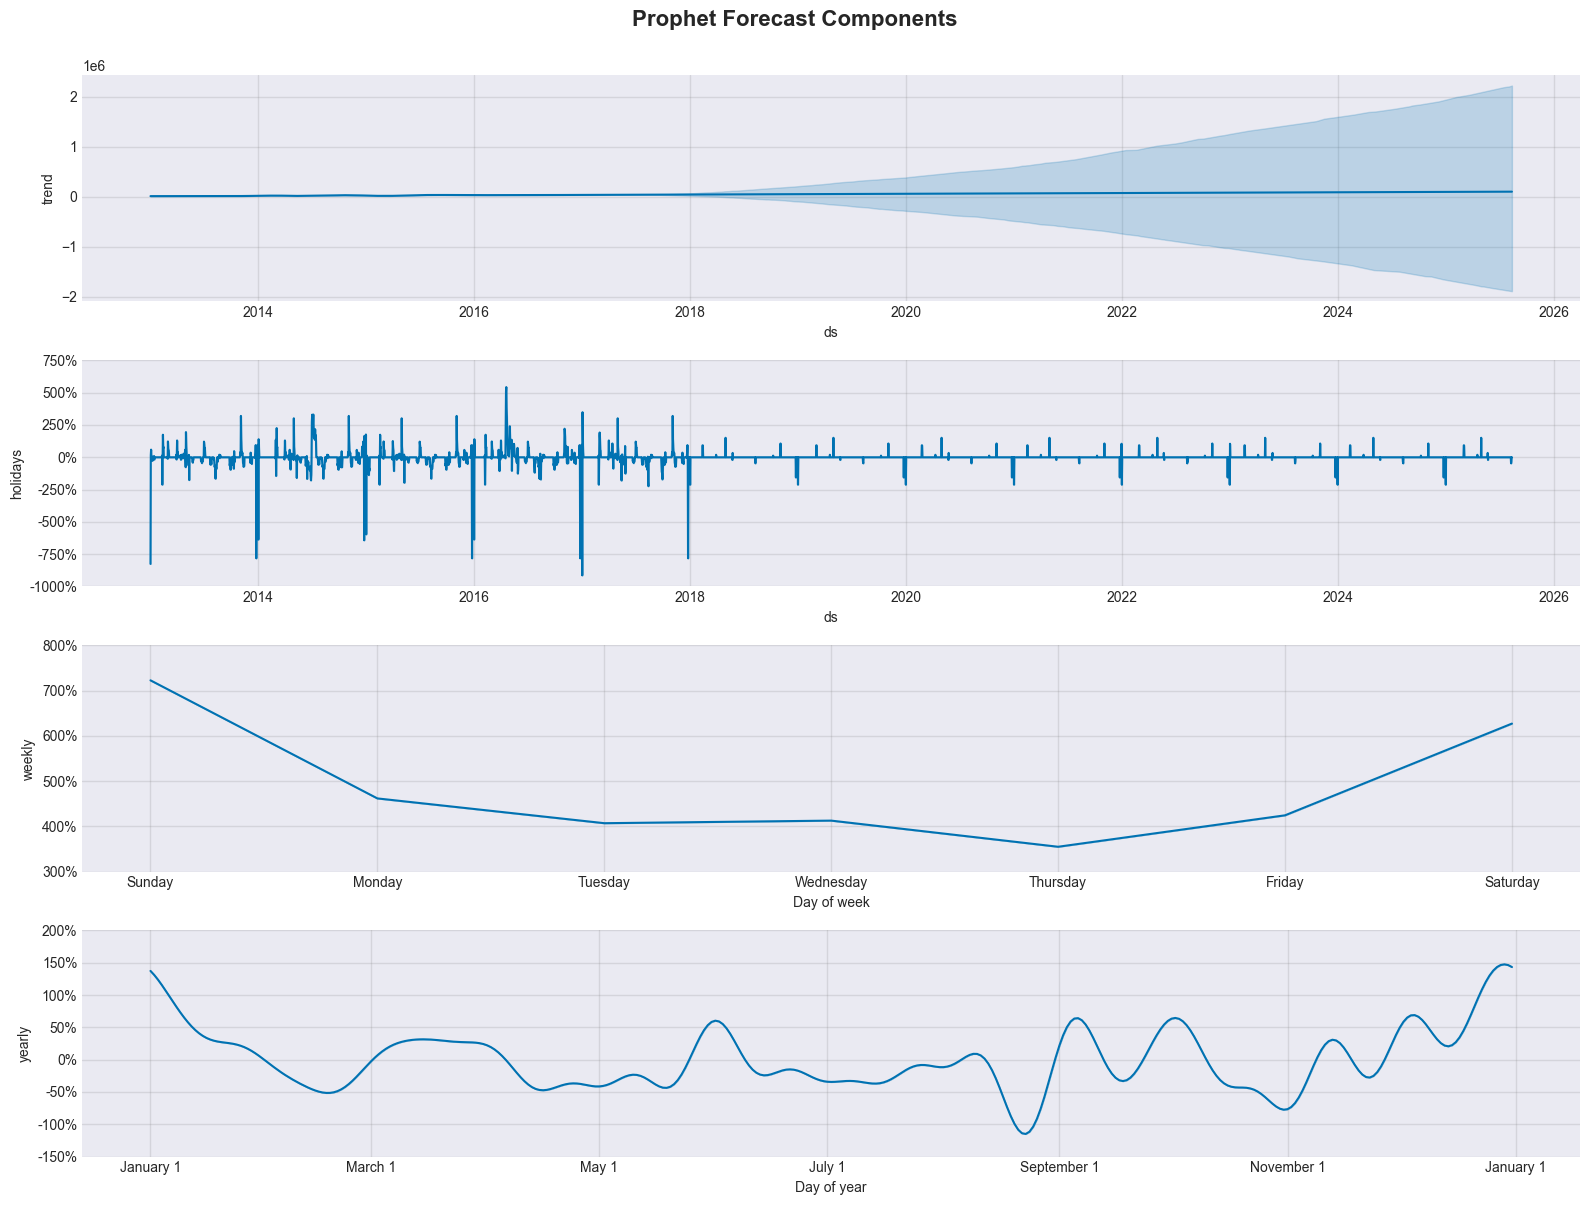

Plot saved: results/06_forecast_components.png


In [17]:
# Plot components (trend, seasonality, holidays)
fig = model.plot_components(forecast, figsize=(16, 12))
plt.suptitle('Prophet Forecast Components', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/06_forecast_components.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/06_forecast_components.png")

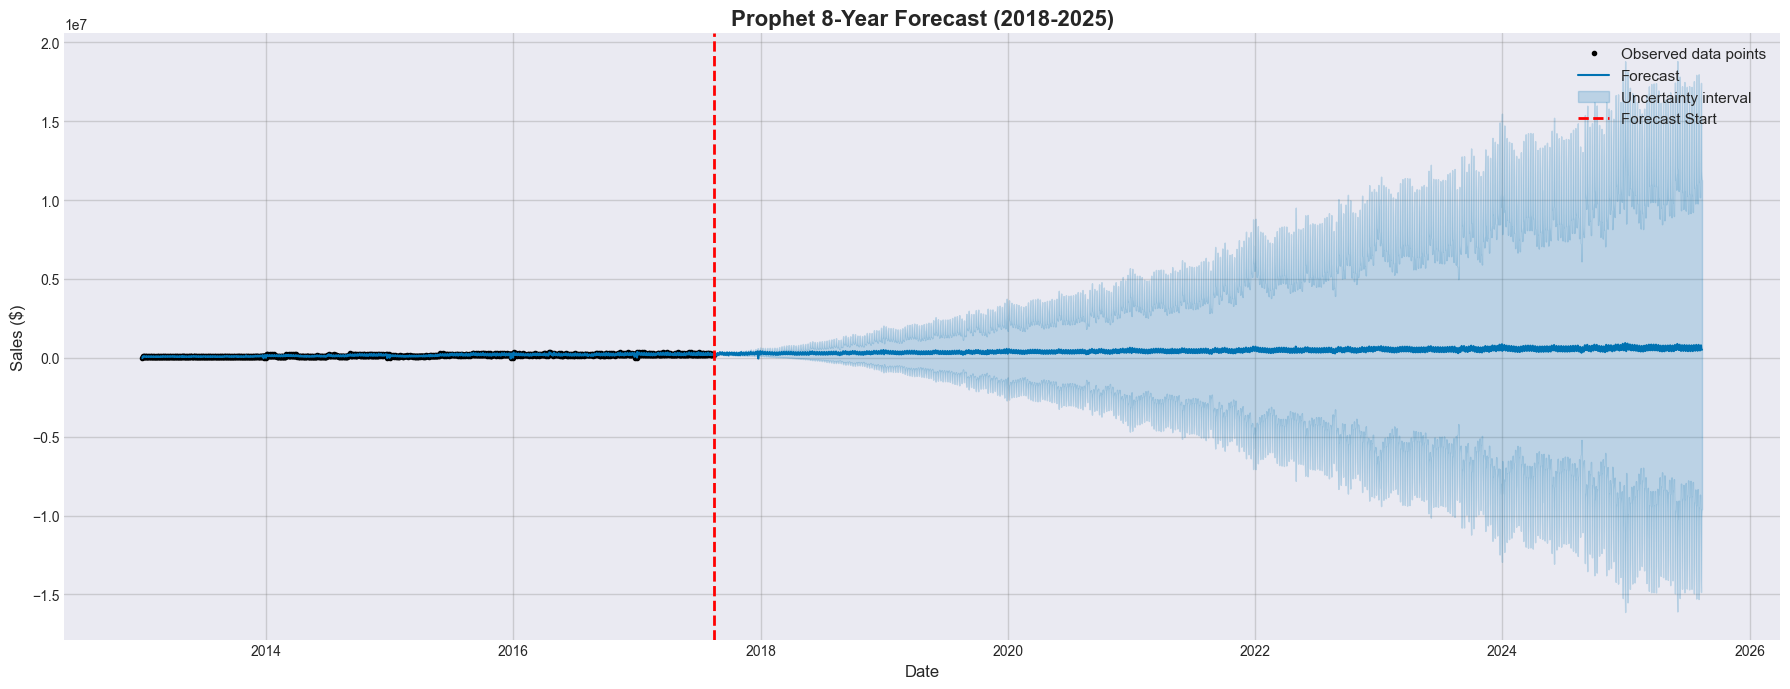

Plot saved: results/07_full_forecast.png


In [18]:
# Plot full forecast
fig = model.plot(forecast, figsize=(18, 7))
ax = fig.gca()
ax.set_title('Prophet 8-Year Forecast (2018-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.grid(True, alpha=0.3)

# Add vertical line to separate training and forecast
ax.axvline(x=train_end, color='red', linestyle='--', linewidth=2, label='Forecast Start')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../results/07_full_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/07_full_forecast.png")

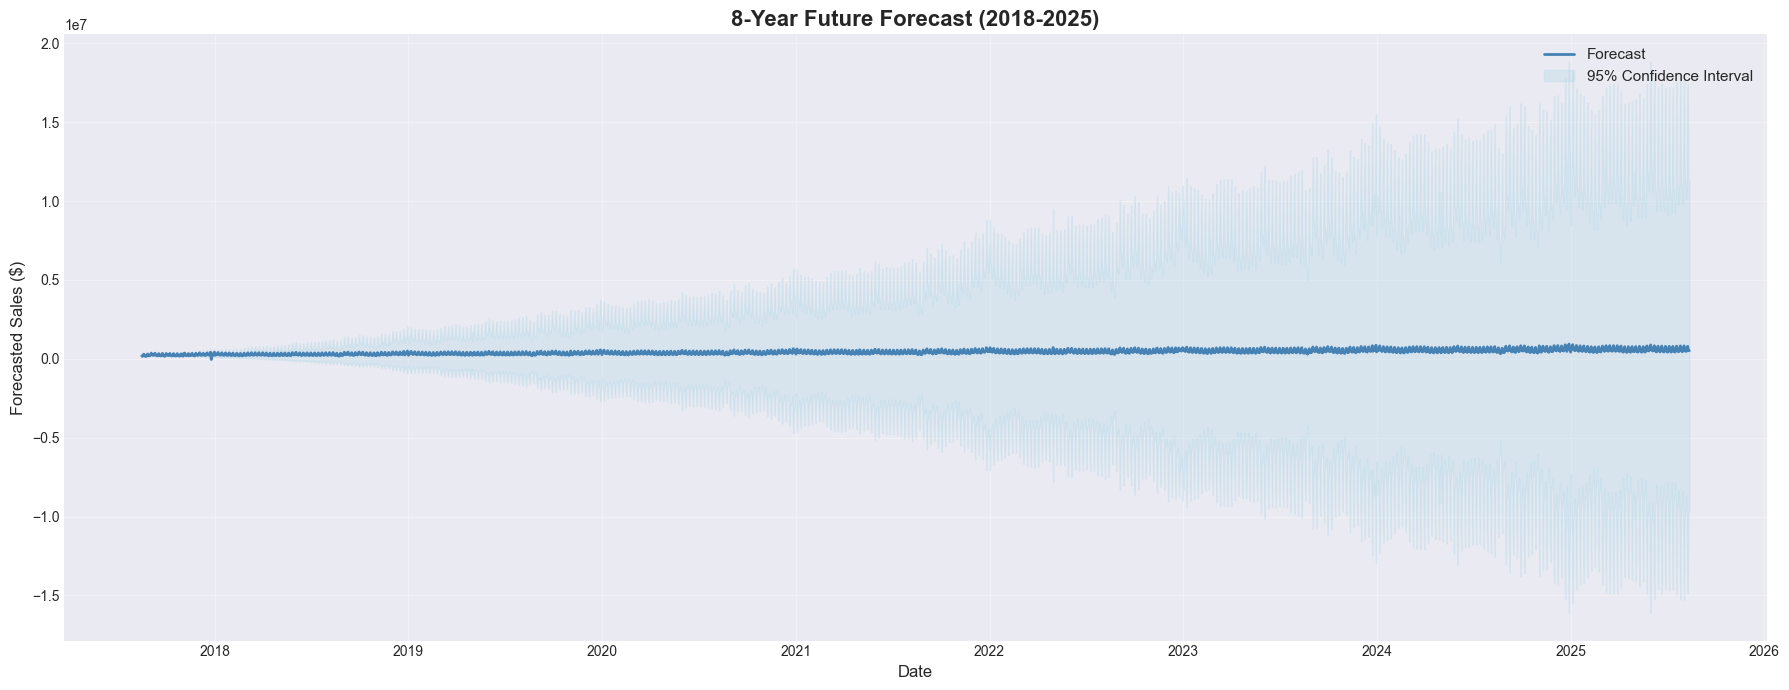

Plot saved: results/08_future_forecast.png


In [19]:
# Plot only future forecast
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(out_sample['ds'], out_sample['yhat'], linewidth=2, label='Forecast', color='steelblue')
ax.fill_between(out_sample['ds'], out_sample['yhat_lower'], out_sample['yhat_upper'],
                 alpha=0.3, label='95% Confidence Interval', color='lightblue')
ax.set_title('8-Year Future Forecast (2018-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Forecasted Sales ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/08_future_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/08_future_forecast.png")

## 5. Train Models cho Tất Cả Stores

Batch training cho 100 stores:
- Loop qua từng store
- Fit Prophet model với data của store đó
- Save model vào file .pkl
- Track progress và errors

In [20]:
# Yearly forecast summary
out_sample['year'] = out_sample['ds'].dt.year
yearly_forecast = out_sample.groupby('year').agg({
    'yhat': ['mean', 'sum', 'std'],
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'
}).reset_index()

yearly_forecast.columns = ['Year', 'Avg_Daily', 'Total', 'Std', 'Total_Lower', 'Total_Upper']
yearly_forecast['Total_M'] = yearly_forecast['Total'] / 1e6  # Convert to millions

print("="*80)
print("YEARLY FORECAST SUMMARY (2018-2025)")
print("="*80)
print(yearly_forecast[['Year', 'Avg_Daily', 'Total_M', 'Std']].to_string(index=False))
print("="*80)

YEARLY FORECAST SUMMARY (2018-2025)
 Year     Avg_Daily    Total_M           Std
 2017 246526.289266  34.020628  66408.424161
 2018 278915.249184 101.804066  65436.603608
 2019 322916.067993 117.864365  75379.001628
 2020 367273.620080 134.422145  84441.300762
 2021 411592.509738 150.231266  94620.943539
 2022 456065.311202 166.463839 104258.953721
 2023 500780.905652 182.785031 115019.924249
 2024 544286.083026 199.208706 124992.167624
 2025 576081.094392 129.618246 127112.440478


In [21]:
# Calculate CAGR (Compound Annual Growth Rate)
first_year_avg = yearly_forecast[yearly_forecast['Year'] == yearly_forecast['Year'].min()]['Avg_Daily'].values[0]
last_year_avg = yearly_forecast[yearly_forecast['Year'] == yearly_forecast['Year'].max()]['Avg_Daily'].values[0]
num_years = yearly_forecast['Year'].max() - yearly_forecast['Year'].min()

cagr = (last_year_avg / first_year_avg) ** (1 / num_years) - 1

print(f"\nProjected CAGR ({yearly_forecast['Year'].min()}-{yearly_forecast['Year'].max()}): {cagr:.2%}")
print(f"Total 8-Year Forecast: ${yearly_forecast['Total_M'].sum():.2f}M")
print(f"Average Daily Sales (8-year avg): ${out_sample['yhat'].mean():,.2f}")


Projected CAGR (2017-2025): 11.19%
Total 8-Year Forecast: $1216.42M
Average Daily Sales (8-year avg): $416,581.61


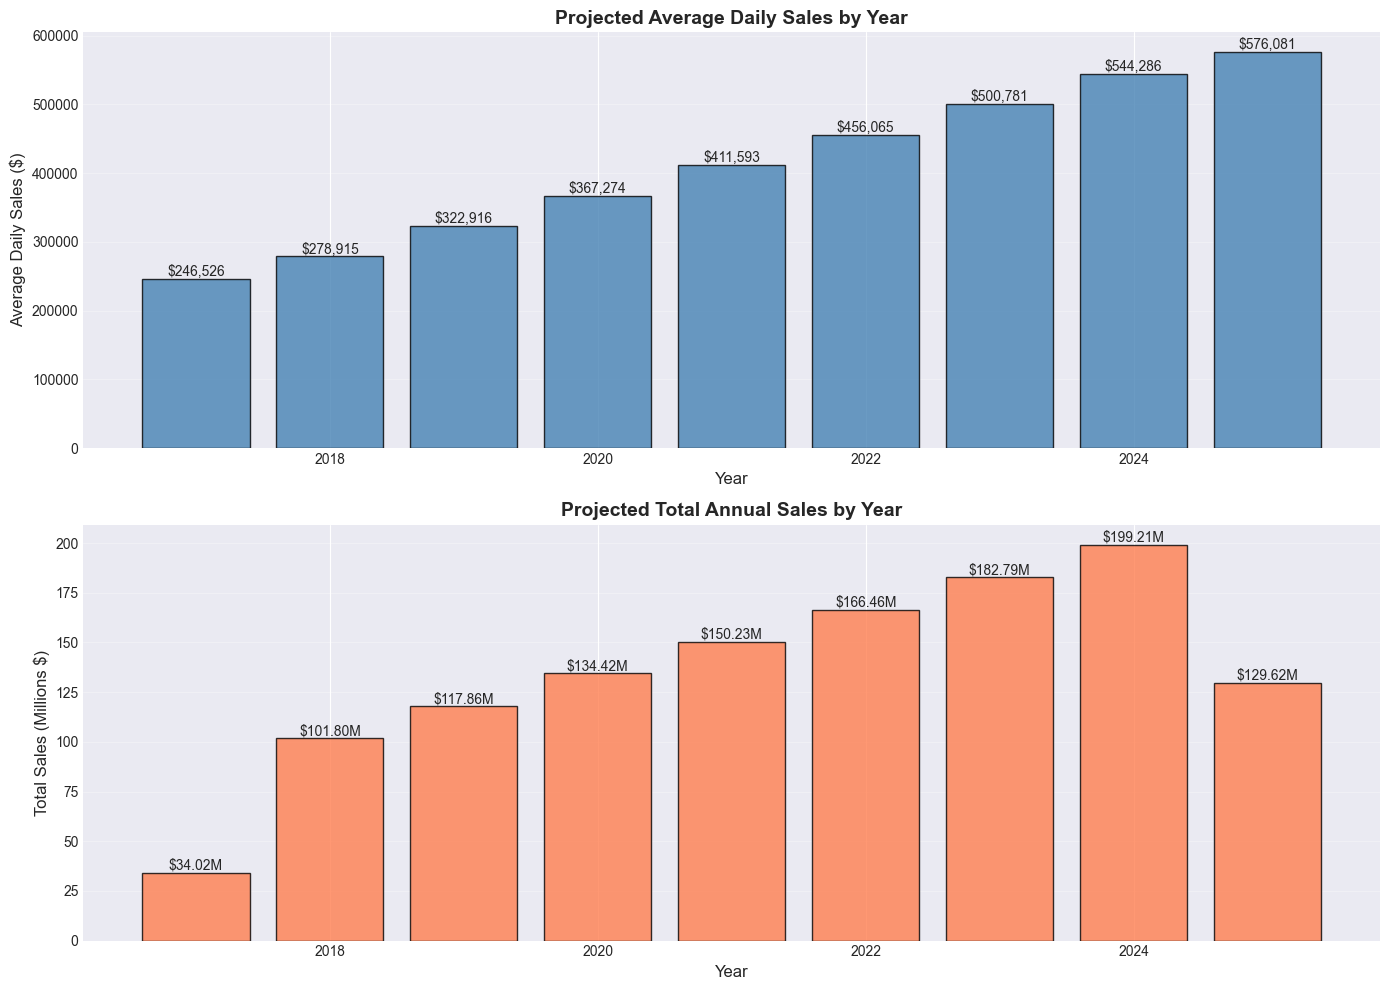

Plot saved: results/09_yearly_forecast.png


In [22]:
# Plot yearly forecast
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Average daily sales by year
axes[0].bar(yearly_forecast['Year'], yearly_forecast['Avg_Daily'], 
            alpha=0.8, color='steelblue', edgecolor='black')
axes[0].set_title('Projected Average Daily Sales by Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Average Daily Sales ($)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, row in yearly_forecast.iterrows():
    axes[0].text(row['Year'], row['Avg_Daily'], f"${row['Avg_Daily']:,.0f}",
                 ha='center', va='bottom', fontsize=10)

# Total sales by year
axes[1].bar(yearly_forecast['Year'], yearly_forecast['Total_M'], 
            alpha=0.8, color='coral', edgecolor='black')
axes[1].set_title('Projected Total Annual Sales by Year', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Total Sales (Millions $)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, row in yearly_forecast.iterrows():
    axes[1].text(row['Year'], row['Total_M'], f"${row['Total_M']:.2f}M",
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/09_yearly_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/09_yearly_forecast.png")

## 6. Generate Forecasts cho Tất Cả Stores

Tạo dự báo cho 100 stores:
- Load từng model đã train
- Predict cho time range 2018-2025
- Combine tất cả forecasts vào 1 dataframe
- Export ra CSV file

In [23]:
# Save full forecast
forecast.to_csv('../results/prophet_forecast_full.csv', index=False)
print("Full forecast saved: results/prophet_forecast_full.csv")

# Save out-of-sample forecast (2018-2025)
out_sample_simple = out_sample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
out_sample_simple.columns = ['Date', 'Forecast', 'Lower_95', 'Upper_95']
out_sample_simple.to_csv('../results/forecast_2018_2025.csv', index=False)
print("Future forecast saved: results/forecast_2018_2025.csv")

# Save yearly summary
yearly_forecast.to_csv('../results/yearly_forecast_summary.csv', index=False)
print("Yearly summary saved: results/yearly_forecast_summary.csv")

# Save model evaluation metrics
metrics = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'RMSE', 'Coverage'],
    'Value': [mae, mape, rmse, coverage],
    'Unit': ['$', '%', '$', '%']
})
metrics.to_csv('../results/model_metrics.csv', index=False)
print("Model metrics saved: results/model_metrics.csv")

Full forecast saved: results/prophet_forecast_full.csv
Future forecast saved: results/forecast_2018_2025.csv
Yearly summary saved: results/yearly_forecast_summary.csv
Model metrics saved: results/model_metrics.csv


In [24]:
# Save the trained model
import pickle

with open('../ml-models/revenue_prediction.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved: ml-models/revenue_prediction.pkl")

Model saved: ml-models/revenue_prediction.pkl


## 7. Evaluate Model Performance

Đánh giá performance của tất cả models:
- Tính MAE, RMSE, MAPE, R² cho từng store
- Tạo summary metrics table
- Xác định top/bottom performing stores
- Export metrics ra CSV

In [25]:
print("\n" + "="*80)
print("PROPHET FORECASTING - FINAL SUMMARY")
print("="*80)

print("\nTRAINING DATA:")
print(f"  • Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"  • Total days: {len(train_df)} days")
print(f"  • Average daily sales: ${train_df['y'].mean():,.2f}")
print(f"  • Total revenue: ${train_df['y'].sum():,.2f}")

print("\nMODEL PERFORMANCE (In-Sample):")
print(f"  • MAE: ${mae:,.2f}")
print(f"  • MAPE: {mape:.2f}%")
print(f"  • RMSE: ${rmse:,.2f}")
print(f"  • Coverage (95% CI): {coverage:.2f}%")

print("\nFORECAST (2018-2025):")
print(f"  • Forecast period: {out_sample['ds'].min()} to {out_sample['ds'].max()}")
print(f"  • Total days: {len(out_sample)} days ({len(out_sample)/365:.1f} years)")
print(f"  • Average daily sales: ${out_sample['yhat'].mean():,.2f}")
print(f"  • Total forecasted revenue: ${yearly_forecast['Total_M'].sum():.2f}M")
print(f"  • Projected CAGR: {cagr:.2%}")

print("\nSAVED FILES:")
print("  • results/prophet_forecast_full.csv - Full forecast with all components")
print("  • results/forecast_2018_2025.csv - Future forecast (2018-2025)")
print("  • results/yearly_forecast_summary.csv - Yearly aggregated forecast")
print("  • results/model_metrics.csv - Model evaluation metrics")
print("  • results/prophet_model.pkl - Trained Prophet model")
print("  • results/*.png - 9 visualization plots")

print("\n" + "="*80)
print("PROPHET FORECASTING COMPLETE!")
print("="*80)


PROPHET FORECASTING - FINAL SUMMARY

TRAINING DATA:
  • Period: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
  • Total days: 1688 days
  • Average daily sales: $153,488.41
  • Total revenue: $259,088,431.58

MODEL PERFORMANCE (In-Sample):
  • MAE: $11,623.18
  • MAPE: 9.98%
  • RMSE: $16,331.83
  • Coverage (95% CI): 93.78%

FORECAST (2018-2025):
  • Forecast period: 2017-08-16 00:00:00 to 2025-08-13 00:00:00
  • Total days: 2920 days (8.0 years)
  • Average daily sales: $416,581.61
  • Total forecasted revenue: $1216.42M
  • Projected CAGR: 11.19%

SAVED FILES:
  • results/prophet_forecast_full.csv - Full forecast with all components
  • results/forecast_2018_2025.csv - Future forecast (2018-2025)
  • results/yearly_forecast_summary.csv - Yearly aggregated forecast
  • results/model_metrics.csv - Model evaluation metrics
  • results/prophet_model.pkl - Trained Prophet model
  • results/*.png - 9 visualization plots

PROPHET FORECASTING COMPLETE!


### 7.1. Load Forecast Results

Load kết quả dự báo đã generate:
- Read từ file forecast_2018_2025.csv
- Kiểm tra data structure
- Preview top rows

In [26]:
# Load data by store
df_stores = pd.read_csv('../data/daily_sales_by_store.csv')
df_stores['ds'] = pd.to_datetime(df_stores['ds'])

print(f"Data by store shape: {df_stores.shape}")
print(f"Date range: {df_stores['ds'].min()} to {df_stores['ds'].max()}")
print(f"Number of stores: {df_stores['store_nbr'].nunique()}")
print(f"Total revenue: ${df_stores['y'].sum():,.2f}")
print(f"\nFirst rows:")
df_stores.head(10)

Data by store shape: (90936, 9)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Number of stores: 54
Total revenue: $1,073,644,952.20

First rows:


,ds,store_nbr,city,state,type,cluster,y,promotions,transactions
0,2013-01-01,1,Quito,Pichincha,D,13,0.0,0,0.0
1,2013-01-01,2,Quito,Pichincha,D,13,0.0,0,0.0
2,2013-01-01,3,Quito,Pichincha,D,8,0.0,0,0.0
3,2013-01-01,4,Quito,Pichincha,D,9,0.0,0,0.0
4,2013-01-01,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,0.0,0,0.0
5,2013-01-01,6,Quito,Pichincha,D,13,0.0,0,0.0
6,2013-01-01,7,Quito,Pichincha,D,8,0.0,0,0.0
7,2013-01-01,8,Quito,Pichincha,D,8,0.0,0,0.0
8,2013-01-01,9,Quito,Pichincha,B,6,0.0,0,0.0
9,2013-01-01,10,Quito,Pichincha,C,15,0.0,0,0.0


In [27]:
# Store performance summary
store_summary = df_stores.groupby(['store_nbr', 'city', 'state', 'type', 'cluster']).agg({
    'y': ['sum', 'mean', 'std'],
    'transactions': 'sum'
}).reset_index()

store_summary.columns = ['store_nbr', 'city', 'state', 'type', 'cluster', 
                         'total_revenue', 'avg_daily_sales', 'std_sales', 'total_transactions']
store_summary = store_summary.sort_values('total_revenue', ascending=False)

print("="*80)
print("TOP 15 STORES BY REVENUE")
print("="*80)
print(store_summary[['store_nbr', 'city', 'type', 'total_revenue', 'avg_daily_sales']].head(15).to_string(index=False))
print("\n" + "="*80)

TOP 15 STORES BY REVENUE
 store_nbr      city type  total_revenue  avg_daily_sales
        44     Quito    A   6.208755e+07     36869.093379
        45     Quito    A   5.449801e+07     32362.238965
        47     Quito    A   5.094831e+07     30254.340891
         3     Quito    D   5.048191e+07     29977.381345
        49     Quito    A   4.342010e+07     25783.904860
        46     Quito    A   4.189606e+07     24878.896747
        48     Quito    A   3.593313e+07     21337.963346
        51 Guayaquil    A   3.291149e+07     19543.639868
         8     Quito    D   3.049429e+07     18108.246394
        50    Ambato    A   2.865302e+07     17014.857853
        11   Cayambe    B   2.832556e+07     16820.402899
         7     Quito    D   2.695205e+07     16004.780037
         9     Quito    B   2.640944e+07     15682.565953
         6     Quito    D   2.518368e+07     14954.679333
        24 Guayaquil    D   2.376773e+07     14113.855524



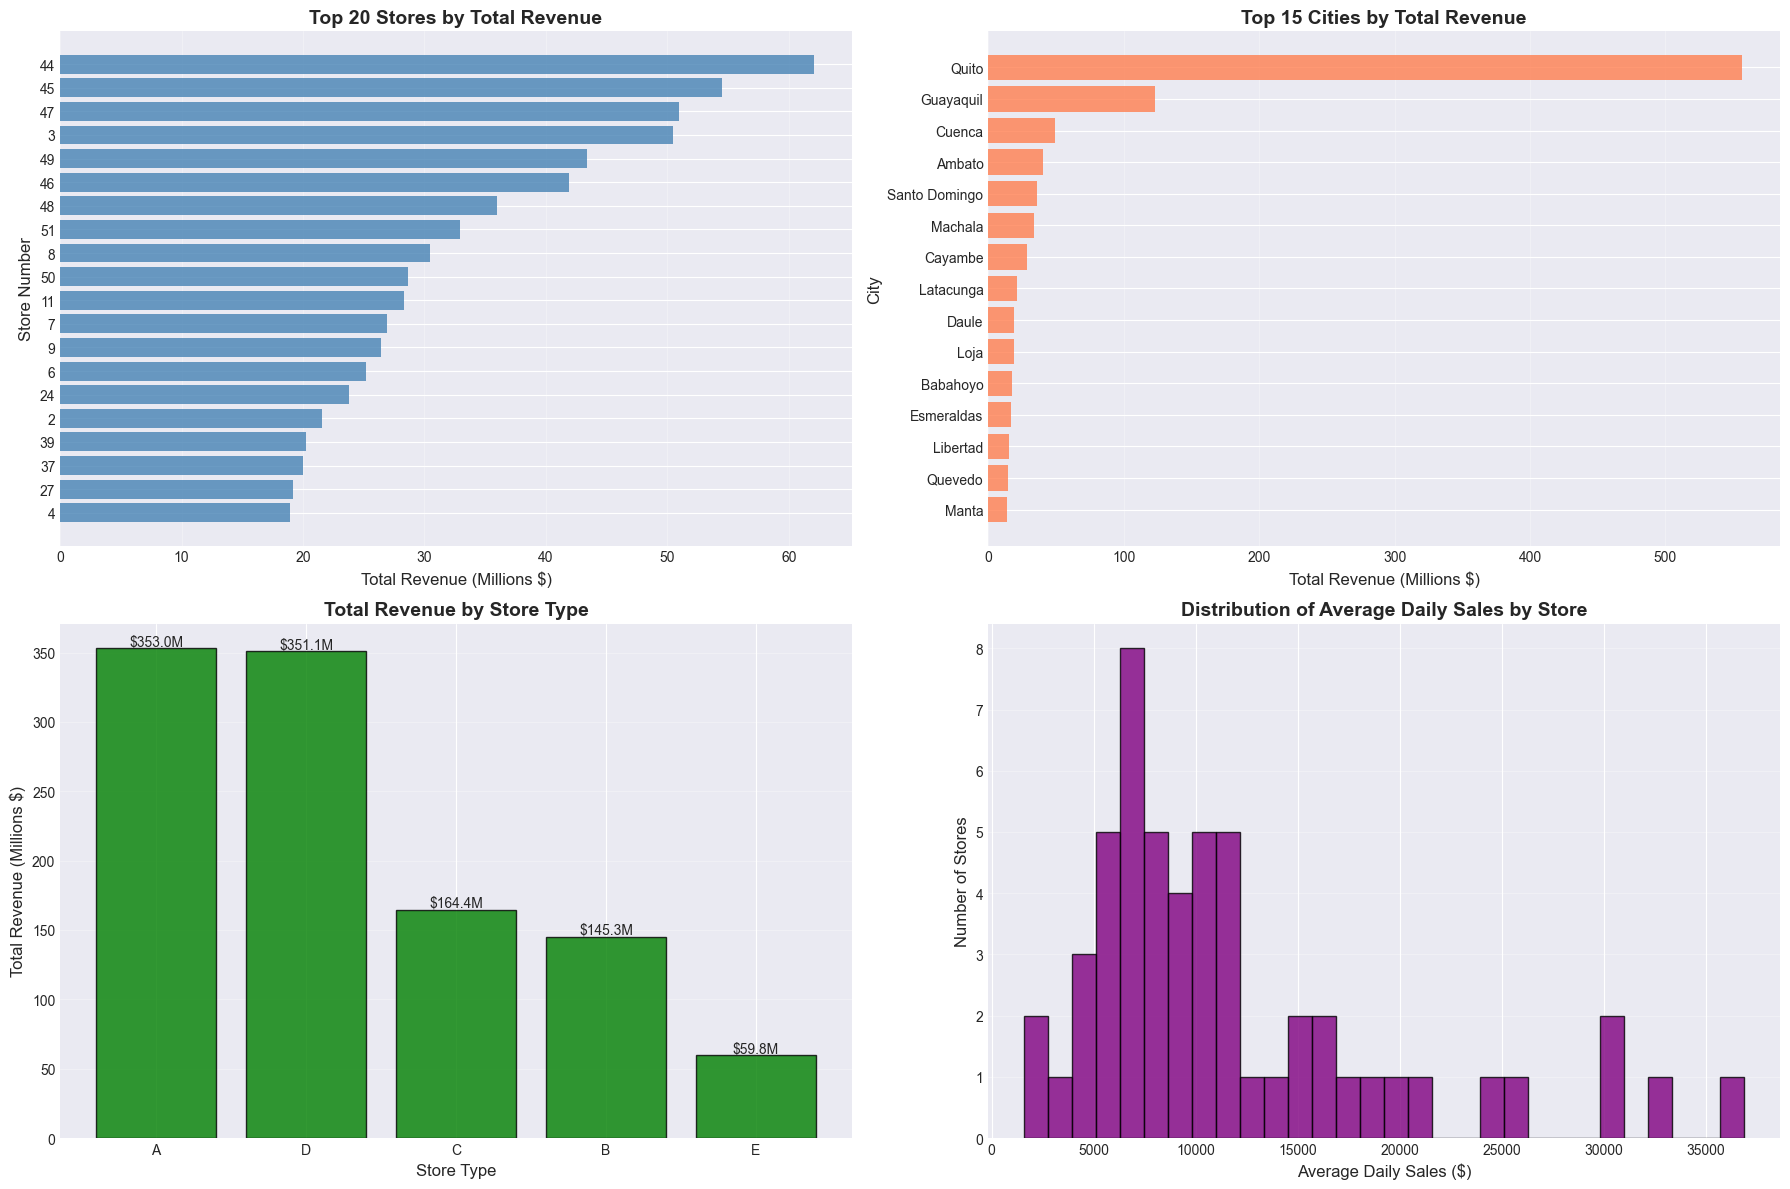

Plot saved: results/10_store_performance.png


In [28]:
# Visualize store performance
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 20 stores by revenue
top_20_stores = store_summary.head(20)
axes[0, 0].barh(top_20_stores['store_nbr'].astype(str), top_20_stores['total_revenue']/1e6, 
                alpha=0.8, color='steelblue')
axes[0, 0].set_title('Top 20 Stores by Total Revenue', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Revenue (Millions $)', fontsize=12)
axes[0, 0].set_ylabel('Store Number', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

# Revenue by city (top 15)
city_revenue = df_stores.groupby('city')['y'].sum().sort_values(ascending=False).head(15)
axes[0, 1].barh(city_revenue.index, city_revenue.values/1e6, alpha=0.8, color='coral')
axes[0, 1].set_title('Top 15 Cities by Total Revenue', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Total Revenue (Millions $)', fontsize=12)
axes[0, 1].set_ylabel('City', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# Revenue by store type
type_revenue = df_stores.groupby('type')['y'].sum().sort_values(ascending=False)
axes[1, 0].bar(type_revenue.index, type_revenue.values/1e6, alpha=0.8, color='green', edgecolor='black')
axes[1, 0].set_title('Total Revenue by Store Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Store Type', fontsize=12)
axes[1, 0].set_ylabel('Total Revenue (Millions $)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, val) in enumerate(type_revenue.items()):
    axes[1, 0].text(i, val/1e6, f'${val/1e6:.1f}M', ha='center', va='bottom', fontsize=10)

# Distribution of average daily sales by store
axes[1, 1].hist(store_summary['avg_daily_sales'], bins=30, alpha=0.8, color='purple', edgecolor='black')
axes[1, 1].set_title('Distribution of Average Daily Sales by Store', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Daily Sales ($)', fontsize=12)
axes[1, 1].set_ylabel('Number of Stores', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/10_store_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/10_store_performance.png")

## 8. Visualization và Analysis

Tạo visualizations để phân tích kết quả:
- Forecast plots cho top performing stores
- Comparison charts giữa stores
- Seasonality patterns
- Error distribution

In [29]:
# Get top 5 stores
top_5_stores = store_summary.head(5)['store_nbr'].tolist()
print(f"Top 5 stores: {top_5_stores}")

# Dictionary to store forecasts
store_forecasts = {}
store_models = {}

# Simplified config for individual stores
store_config = {
    'growth': 'linear',
    'changepoint_prior_scale': 0.05,
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': 10,
    'weekly_seasonality': 5,
    'daily_seasonality': False,
    'interval_width': 0.95
}

print("\n" + "="*80)
print("TRAINING PROPHET MODELS FOR TOP 5 STORES")
print("="*80)

for store_id in top_5_stores:
    print(f"\nStore {store_id}:")
    
    # Prepare data for this store
    store_data = df_stores[df_stores['store_nbr'] == store_id][['ds', 'y']].copy()
    store_info = df_stores[df_stores['store_nbr'] == store_id][['city', 'type']].iloc[0]
    
    print(f"  City: {store_info['city']}, Type: {store_info['type']}")
    print(f"  Data points: {len(store_data)}")
    print(f"  Avg daily sales: ${store_data['y'].mean():,.2f}")
    
    # Train model
    model_store = Prophet(holidays=holidays_prophet if has_holidays else None, **store_config)
    if has_holidays:
        model_store.add_country_holidays(country_name='EC')
    
    model_store.fit(store_data)
    
    # Forecast 2 years (730 days)
    future_store = model_store.make_future_dataframe(periods=730, freq='D')
    forecast_store = model_store.predict(future_store)
    
    # Store results
    store_forecasts[store_id] = {
        'data': store_data,
        'forecast': forecast_store,
        'city': store_info['city'],
        'type': store_info['type']
    }
    store_models[store_id] = model_store
    
    print(f"  Model trained and forecast generated for 2 years")

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)

Top 5 stores: [44, 45, 47, 3, 49]

TRAINING PROPHET MODELS FOR TOP 5 STORES

Store 44:
  City: Quito, Type: A
  Data points: 1684
  Avg daily sales: $36,869.09


16:54:01 - cmdstanpy - INFO - Chain [1] start processing
16:54:04 - cmdstanpy - INFO - Chain [1] done processing
16:54:04 - cmdstanpy - INFO - Chain [1] done processing


  Model trained and forecast generated for 2 years

Store 45:
  City: Quito, Type: A
  Data points: 1684
  Avg daily sales: $32,362.24


16:54:06 - cmdstanpy - INFO - Chain [1] start processing
16:54:09 - cmdstanpy - INFO - Chain [1] done processing
16:54:09 - cmdstanpy - INFO - Chain [1] done processing


  Model trained and forecast generated for 2 years

Store 47:
  City: Quito, Type: A
  Data points: 1684
  Avg daily sales: $30,254.34


16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing


  Model trained and forecast generated for 2 years

Store 3:
  City: Quito, Type: D
  Data points: 1684
  Avg daily sales: $29,977.38


16:54:16 - cmdstanpy - INFO - Chain [1] start processing
16:54:18 - cmdstanpy - INFO - Chain [1] done processing
16:54:18 - cmdstanpy - INFO - Chain [1] done processing


  Model trained and forecast generated for 2 years

Store 49:
  City: Quito, Type: A
  Data points: 1684
  Avg daily sales: $25,783.90


16:54:20 - cmdstanpy - INFO - Chain [1] start processing
16:54:22 - cmdstanpy - INFO - Chain [1] done processing
16:54:22 - cmdstanpy - INFO - Chain [1] done processing


  Model trained and forecast generated for 2 years

ALL MODELS TRAINED SUCCESSFULLY!


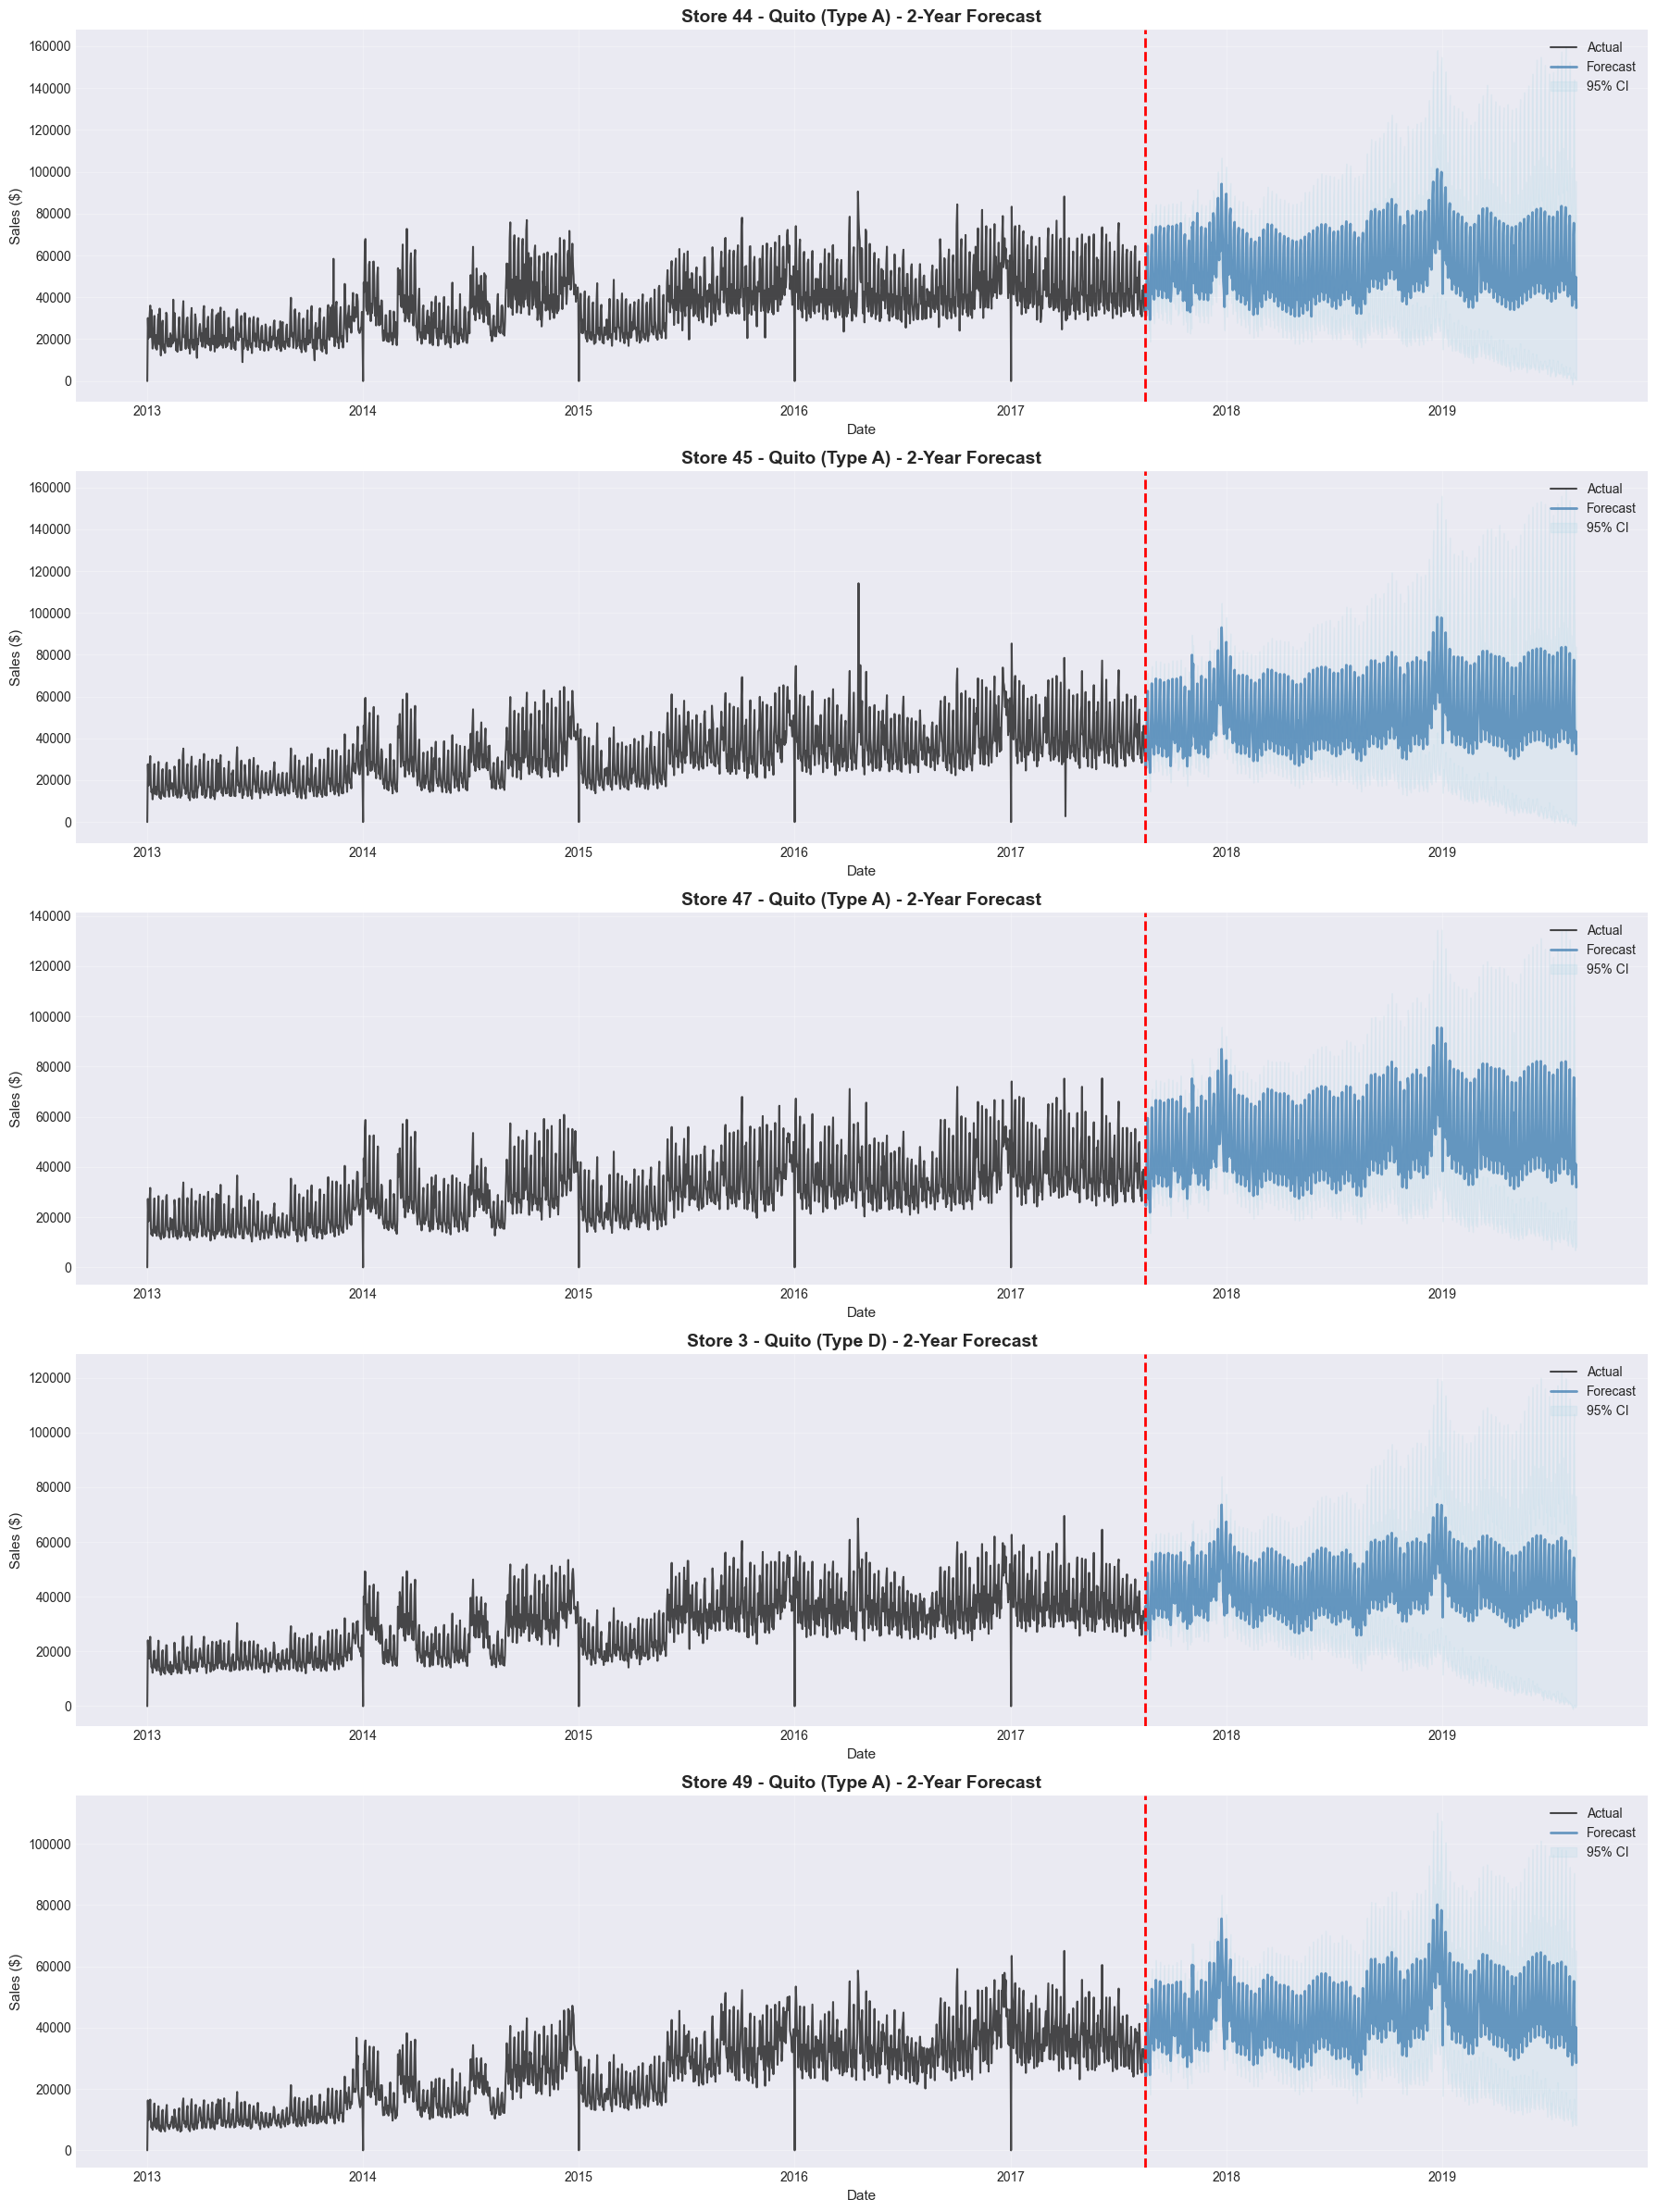

Plot saved: results/11_top5_stores_forecast.png


In [30]:
# Visualize forecasts for top 5 stores
fig, axes = plt.subplots(5, 1, figsize=(18, 24))

for idx, store_id in enumerate(top_5_stores):
    data = store_forecasts[store_id]
    ax = axes[idx]
    
    # Plot actual data
    ax.plot(data['data']['ds'], data['data']['y'], 
            label='Actual', linewidth=1.5, alpha=0.7, color='black')
    
    # Plot forecast
    train_end_store = data['data']['ds'].max()
    future_forecast = data['forecast'][data['forecast']['ds'] > train_end_store]
    
    ax.plot(future_forecast['ds'], future_forecast['yhat'], 
            label='Forecast', linewidth=2, alpha=0.8, color='steelblue')
    ax.fill_between(future_forecast['ds'], 
                     future_forecast['yhat_lower'], 
                     future_forecast['yhat_upper'],
                     alpha=0.2, color='lightblue', label='95% CI')
    
    # Vertical line at forecast start
    ax.axvline(x=train_end_store, color='red', linestyle='--', linewidth=2)
    
    # Title and labels
    ax.set_title(f'Store {store_id} - {data["city"]} (Type {data["type"]}) - 2-Year Forecast', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Sales ($)', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/11_top5_stores_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: results/11_top5_stores_forecast.png")

In [31]:
# Summary forecast for top 5 stores
print("="*90)
print("2-YEAR FORECAST SUMMARY FOR TOP 5 STORES")
print("="*90)

summary_data = []
for store_id in top_5_stores:
    data = store_forecasts[store_id]
    future_forecast = data['forecast'][data['forecast']['ds'] > data['data']['ds'].max()]
    
    # Calculate yearly forecast
    future_forecast['year'] = pd.to_datetime(future_forecast['ds']).dt.year
    yearly = future_forecast.groupby('year')['yhat'].agg(['mean', 'sum']).reset_index()
    
    # Historical average
    hist_avg = data['data']['y'].mean()
    forecast_avg = future_forecast['yhat'].mean()
    growth = ((forecast_avg - hist_avg) / hist_avg) * 100
    
    summary_data.append({
        'Store': store_id,
        'City': data['city'],
        'Type': data['type'],
        'Hist_Avg_Daily': hist_avg,
        'Forecast_Avg_Daily': forecast_avg,
        'Growth_%': growth,
        'Year1_Total': yearly[yearly['year'] == yearly['year'].min()]['sum'].values[0],
        'Year2_Total': yearly[yearly['year'] == yearly['year'].max()]['sum'].values[0]
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*90)
print(f"Total 2-Year Forecast (Top 5): ${summary_df['Year1_Total'].sum() + summary_df['Year2_Total'].sum():,.2f}")
print("="*90)

2-YEAR FORECAST SUMMARY FOR TOP 5 STORES
 Store  City Type  Hist_Avg_Daily  Forecast_Avg_Daily  Growth_%  Year1_Total  Year2_Total
    44 Quito    A    36869.093379        55006.655091 49.194488 7.541452e+06 1.268762e+07
    45 Quito    A    32362.238965        50763.439944 56.860099 6.664314e+06 1.210646e+07
    47 Quito    A    30254.340891        49402.774797 63.291526 6.443126e+06 1.184019e+07
     3 Quito    D    29977.381345        43650.512010 45.611491 5.954390e+06 1.009519e+07
    49 Quito    A    25783.904860        44739.568798 73.517429 6.031451e+06 1.046168e+07

Total 2-Year Forecast (Top 5): $89,825,868.89


In [32]:
# Save store forecasts
print("Saving store-level forecasts...")

# Create directory for store forecasts if not exists
import os
os.makedirs('../results/store_forecasts', exist_ok=True)

for store_id in top_5_stores:
    data = store_forecasts[store_id]
    future_only = data['forecast'][data['forecast']['ds'] > data['data']['ds'].max()]
    
    # Save forecast
    output_file = f'../results/store_forecasts/store_{store_id}_forecast.csv'
    future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(output_file, index=False)
    print(f"  Saved: {output_file}")

# Save summary
summary_df.to_csv('../results/store_forecasts/top5_summary.csv', index=False)
print(f"\nSummary saved: ../results/store_forecasts/top5_summary.csv")

# Save store performance summary
store_summary.to_csv('../results/store_performance_summary.csv', index=False)
print(f"Store performance saved: ../results/store_performance_summary.csv")

print("\nAll store-level forecasts saved successfully!")

Saving store-level forecasts...
  Saved: ../results/store_forecasts/store_44_forecast.csv
  Saved: ../results/store_forecasts/store_45_forecast.csv
  Saved: ../results/store_forecasts/store_47_forecast.csv
  Saved: ../results/store_forecasts/store_3_forecast.csv
  Saved: ../results/store_forecasts/store_49_forecast.csv

Summary saved: ../results/store_forecasts/top5_summary.csv
Store performance saved: ../results/store_performance_summary.csv

All store-level forecasts saved successfully!


## 9. Save Models và Results

Lưu tất cả outputs:
- Serialize 100 Prophet models thành .pkl files
- Export forecast results ra CSV
- Save model metrics
- Create metadata files

In [33]:
import pickle
import os

# Create directory for store models if it doesn't exist
store_models_dir = '../ml-models/store_models/'
os.makedirs(store_models_dir, exist_ok=True)

# Save each store model
for store_nbr, model in store_models.items():
    model_path = os.path.join(store_models_dir, f'store_{store_nbr}_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f'Saved model for store {store_nbr} to {model_path}')

# Also save stores metadata
if 'store_df' in locals():
    metadata_path = os.path.join(store_models_dir, 'stores_metadata.csv')
    store_df.to_csv(metadata_path, index=False)
    print(f'Saved stores metadata to {metadata_path}')

print(f'\nTotal {len(store_models)} store models saved successfully!')

Saved model for store 44 to ../ml-models/store_models/store_44_model.pkl
Saved model for store 45 to ../ml-models/store_models/store_45_model.pkl
Saved model for store 47 to ../ml-models/store_models/store_47_model.pkl
Saved model for store 3 to ../ml-models/store_models/store_3_model.pkl
Saved model for store 49 to ../ml-models/store_models/store_49_model.pkl

Total 5 store models saved successfully!
